In [6]:
import os
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import numpy as np
from math import sqrt

import data_analysis.static_positioning as sp
import data_analysis.static_positioning_simplified as sps
from sink.bp_kalman import BpKalman

In [7]:
data_dir = "data/experiment2"

ip1 = "192.168.8.21"
ip2 = "192.168.8.22"
ip3 = "192.168.8.23"
ip4 = "192.168.8.24"

exp_0_1 = ("exp_0_1", (0, 1))
exp_0_2 = ("exp_0_2", (0, 2))
exp_0_3 = ("exp_0_3", (0, 3))
exp_0_4 = ("exp_0_4", (0, 4))
exp_1_0 = ("exp_1_0", (1, 0))
exp_1_1 = ("exp_1_1", (1, 1))
exp_1_2 = ("exp_1_2", (1, 2))
exp_1_3 = ("exp_1_3", (1, 3))
exp_1_4 = ("exp_1_4", (1, 4))
exp_1_5 = ("exp_1_5", (1, 5))
exp_2_0 = ("exp_2_0", (2, 0))
exp_2_1 = ("exp_2_1", (2, 1))
exp_2_2 = ("exp_2_2", (2, 2))
exp_2_3 = ("exp_2_3", (2, 3))
exp_2_4 = ("exp_2_4", (2, 4))
exp_2_5 = ("exp_2_5", (2, 5))
exp_3_0 = ("exp_3_0", (3, 0))
exp_3_1 = ("exp_3_1", (3, 1))
exp_3_2 = ("exp_3_2", (3, 2))
exp_3_3 = ("exp_3_3", (3, 3))
exp_3_4 = ("exp_3_4", (3, 4))
exp_3_5 = ("exp_3_5", (3, 5))
exp_4_0 = ("exp_4_0", (4, 0))
exp_4_1 = ("exp_4_1", (4, 1))
exp_4_2 = ("exp_4_2", (4, 2))
exp_4_3 = ("exp_4_3", (4, 3))
exp_4_4 = ("exp_4_4", (4, 4))
exp_4_5 = ("exp_4_5", (4, 5))
exp_5_1 = ("exp_5_1", (5, 1))
exp_5_2 = ("exp_5_2", (5, 2))
exp_5_3 = ("exp_5_3", (5, 3))
exp_5_4 = ("exp_5_4", (5, 4))
experiments = [exp_0_1, exp_0_2, exp_0_3, exp_0_4,
               exp_1_0, exp_1_1, exp_1_2, exp_1_3, exp_1_4, exp_1_5,
               exp_2_0, exp_2_1, exp_2_2, exp_2_3, exp_2_4, exp_2_5,
               exp_3_0, exp_3_1, exp_3_2, exp_3_3, exp_3_4, exp_3_5,
               exp_4_0, exp_4_1, exp_4_2, exp_4_3, exp_4_4, exp_4_5,
               exp_5_1, exp_5_2, exp_5_3, exp_5_4]
exp_overheating = "exp_overheating"
exp_pos = "exp_pos"

nokia_lap = "22052d"

d1_coord = (0, 0)
d2_coord = (5, 0)
d3_coord = (0, 5)
d4_coord = (5, 5)

coords = (d1_coord, d2_coord, d3_coord, d4_coord)

col_x = "x"
col_y = "y"

room_lim_x = (0, 5)
room_lim_y = (0, 5)

plot_padding = 0.5

plot_lim_x = (room_lim_x[0] - plot_padding, room_lim_x[1] + plot_padding)
plot_lim_y = (room_lim_y[0] - plot_padding, room_lim_y[1] + plot_padding)


In [8]:
def read_dfs(exp_dir):
    dir = f'{data_dir}/{exp_dir}'

    def read_and_index(ip):
        df = pd.read_csv(f'{dir}/{ip}.csv')
        df["timestamp"] = df["timestamp"].astype('datetime64[ns]')
        df.set_index("timestamp", inplace=True, drop=False)
        return df

    df1 = read_and_index(ip1)
    df2 = read_and_index(ip2)
    df3 = read_and_index(ip3)
    df4 = read_and_index(ip4)
    return df1, df2, df3, df4

def plot_results(df, true_point, filter_method, positioning_method, exp_dir):
    
    results_subdir = f'{data_dir}/results'

    ax = df.plot(kind="scatter", x=col_x, y=col_y, xlim=plot_lim_x, ylim=plot_lim_y, alpha=0.3, color="#C5D86D",
                 marker=".", label="Predictions")
    rect1 = patches.Rectangle((room_lim_x[0], room_lim_y[0]), room_lim_x[1], room_lim_y[1], linewidth=1,
                              edgecolor='gray', facecolor='none', linestyle=(0, (1, 10)))
    ax.add_patch(rect1)
    device_coords = np.transpose([d1_coord, d2_coord, d3_coord, d4_coord])
    ax.plot(*device_coords, marker="^", color="#2E294E", linestyle='None', label="Uberteeth")

    ax.set_title("fil: {0}; pos: {1}".format(filter_method, positioning_method))
    ax.set_aspect("equal")

    ax.plot(*true_point, marker="x", color="#D7263D", label="True Point", linestyle='None')
    x_avg = df[col_x].mean()
    y_avg = df[col_y].mean()
    ax.plot(x_avg, y_avg, marker="D", color="#1B998B", label="Prediction Mean", linestyle='None')
    squared_error = df.apply(lambda row: (row[col_x] - true_point[0])**2 + (row[col_y] - true_point[1])**2, axis=1)
    error = squared_error.apply(lambda se: sqrt(se))
    me = error.mean()
    ax.text(-0.4, -0.4, "ME: {:.4f}".format(me))

    lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    file = f'{results_subdir}/{exp_dir}.png'
    print("saving: {0}".format(file))
    os.makedirs(os.path.dirname(file), exist_ok=True)
    plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
    plt.close()
    # plt.show()

def plot_results_simplified(x, y, true_point, exp_dir):
    results_subdir = f'{data_dir}/results'
    fig, ax = plt.subplots(1,1)

    ax.plot(x, y, marker="D", color="#1B998B", label="Prediction", linestyle='None')

    plot_padding = 0.5

    plot_lim_x = (room_lim_x[0] - plot_padding, room_lim_x[1] + plot_padding)
    plot_lim_y = (room_lim_y[0] - plot_padding, room_lim_y[1] + plot_padding)
    ax.set_xlim(*plot_lim_x)
    ax.set_ylim(*plot_lim_y)

    rect1 = patches.Rectangle((room_lim_x[0], room_lim_y[0]), room_lim_x[1], room_lim_y[1], linewidth=1,
                              edgecolor='gray', facecolor='none', linestyle=(0, (1, 10)))
    ax.add_patch(rect1)
    device_coords = np.transpose([d1_coord, d2_coord, d3_coord, d4_coord])
    ax.plot(*device_coords, marker="^", color="#2E294E", linestyle='None', label="Uberteeth")

    me = sqrt((x - true_point[0])**2 + (y - true_point[1])**2)
    ax.text(-0.4, -0.4, "ME: {:.4f}".format(me))
    ax.set_aspect("equal")

    ax.plot(*true_point, marker="x", color="#D7263D", label="True Point", linestyle='None')

    lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    file = f'{results_subdir}/simplified_{exp_dir}.png'
    print("saving: {0}".format(file))
    os.makedirs(os.path.dirname(file), exist_ok=True)
    plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
    plt.close()
    # plt.show()

def read_position_plot(exp_dir, true_point):
    print()
    print(f"positioning for {exp_dir}")
    filter_method = "max"
    positioning_method = "nlls"
    dfs = read_dfs(exp_dir)
    for idx, df in enumerate(dfs):
        print(f'df{idx}: {len(df)} rows')

    avg_len = np.mean([len(df) for df in dfs])
    print(f'average length: {avg_len}')

    res = sp.position_dataset_with_methods(nokia_lap, filter_method, positioning_method, (2.5, 2.5), *dfs, *coords)
    print(f'shape of res: {res.shape}')
    x_avg = res[col_x].mean()
    y_avg = res[col_y].mean()
    me = sqrt((x_avg - true_point[0])**2 + (y_avg - true_point[1])**2)
    print(f'true: {true_point}; estimated: ({x_avg}, {y_avg}); me: {me}')
    plot_results(res, true_point, filter_method, positioning_method, exp_dir)

def read_position_plot_simplified(exp_dir, true_point):
    dfs = read_dfs(exp_dir)

    for idx, df in enumerate(dfs):
        print(f'df{idx}: {len(df)} rows')

    avg_len = np.mean([len(df) for df in dfs])
    print(f'average length: {avg_len}')
    x, y = sps.position_dataset_with_methods(nokia_lap, *dfs, *coords)
    print(f'true: {true_point}; estimated: ({x}, {y})')
    plot_results_simplified(x, y, true_point, exp_dir)

In [5]:
for exp in experiments:
    try:
        read_position_plot(*exp)
    except:
        pass;



positioning for exp_0_1
df0: 52 rows
df1: 16 rows
df2: 12 rows
df3: 9 rows
average length: 22.25
shape of res: (0, 5)

positioning for exp_0_2
df0: 32 rows
df1: 20 rows
df2: 19 rows
df3: 10 rows
average length: 20.25
shape of res: (25, 8)
true: (0, 2); estimated: (2.2027917139200976, 2.426056842904113); me: 2.2436166714259507
saving: data/lenz_rep/results/exp_0_2.png

positioning for exp_0_3
df0: 42 rows
df1: 13 rows
df2: 21 rows
df3: 13 rows
average length: 22.25
shape of res: (0, 5)

positioning for exp_0_4
df0: 58 rows
df1: 23 rows
df2: 18 rows
df3: 13 rows
average length: 28.0
shape of res: (0, 5)

positioning for exp_1_0
df0: 80 rows
df1: 35 rows
df2: 16 rows
df3: 9 rows
average length: 35.0
shape of res: (13, 8)
true: (1, 0); estimated: (1.438272385617471, 1.681050605495052); me: 1.7372431672710964
saving: data/lenz_rep/results/exp_1_0.png

positioning for exp_1_1
df0: 68 rows
df1: 47 rows
df2: 37 rows
df3: 9 rows
average length: 40.25
shape of res: (0, 5)

positioning for exp_1

## Now for the dynamic positioning experiment

In [9]:
pos1 = (1,1)
pos2 = (1,4)
pos3 = (4,1)
pos4 = (4,4)
pos5 = (2.5,2.5)

i1 = (dt.datetime(2020, 7, 13, 18, 4, 30), dt.datetime(2020, 7, 13, 18, 6, 30))
i2 = (dt.datetime(2020, 7, 13, 18, 7, 30), dt.datetime(2020, 7, 13, 18, 9, 30))
i3 = (dt.datetime(2020, 7, 13, 18, 10, 30), dt.datetime(2020, 7, 13, 18, 12, 30))
i4 = (dt.datetime(2020, 7, 13, 18, 13, 30), dt.datetime(2020, 7, 13, 18, 15, 30))
i5 = (dt.datetime(2020, 7, 13, 18, 16, 30), dt.datetime(2020, 7, 13, 18, 18, 30))

In [10]:
def read_position_df():
    df = pd.read_csv(f'{data_dir}/{exp_pos}/positions.csv')
    df["timestamp"] = df["timestamp"].astype('datetime64[ns]')
    df.set_index("timestamp", inplace=True, drop=False)
    df.sort_index(inplace=True)
    return df

def filter_df_w_interval(df, i):
    filter = (df["timestamp"] > i[0]) & (df["timestamp"] < i[1])
    return df[filter]

In [15]:
def kalman_filter_df(df):
    row1 = df.iloc()[0]
    x = row1[col_x]
    y = row1[col_y]
    print((x, 0, y, 0))
    kalman_filter = BpKalman(np.array([x, 0, y, 0]))

    df["t-1"] = df["timestamp"].shift(1)
    df["dt"] = (df["timestamp"] - df["t-1"]).apply(lambda x: x.total_seconds())

    df_from_1 = df[1:]

    def filter(row):
        res = kalman_filter.predict_update(row[col_x], row[col_y], row["dt"])
        row[col_x] = res[0]
        row[col_y] = res[2]
        return row

    return df_from_1.apply(filter, axis=1)

def plot_results_pos(df, true_point, exp_dir):

    results_subdir = f'{data_dir}/results'

    # ax = df.plot(kind="scatter", x=col_x, y=col_y, xlim=plot_lim_x, ylim=plot_lim_y, alpha=0.3, color="#C5D86D",
    ax = df.plot(kind="scatter", legend=None, x=col_x, y=col_y, xlim=plot_lim_x, ylim=plot_lim_y, alpha=0.3, color="#C5D86D",
                 marker=".", label="Predictions")
    rect1 = patches.Rectangle((room_lim_x[0], room_lim_y[0]), room_lim_x[1], room_lim_y[1], linewidth=1,
                              edgecolor='gray', facecolor='none', linestyle=(0, (1, 10)))
    ax.add_patch(rect1)
    device_coords = np.transpose([d1_coord, d2_coord, d3_coord, d4_coord])
    ax.plot(*device_coords, marker="^", color="#2E294E", linestyle='None', label="Uberteeth")

    ax.set_aspect("equal")

    ax.plot(*true_point, marker="x", color="#D7263D", label="True Point", linestyle='None')
    x_avg = df[col_x].mean()
    y_avg = df[col_y].mean()
    ax.plot(x_avg, y_avg, marker="D", color="#1B998B", label="Prediction Mean", linestyle='None')
    squared_error = df.apply(lambda row: (row[col_x] - true_point[0])**2 + (row[col_y] - true_point[1])**2, axis=1)
    error = squared_error.apply(lambda se: sqrt(se))
    me = error.mean()
    ax.text(-0.4, -0.4, "ME: {:.4f}".format(me))

    print(f'shape of res: {df.shape}')
    print(f'true: {true_point}; estimated: ({x_avg}, {y_avg}); me: {me}')

    # lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    # file = f'{results_subdir}/{exp_dir}.png'
    file = f'{results_subdir}/{exp_dir}_cropped.png'
    print("saving: {0}".format(file))
    os.makedirs(os.path.dirname(file), exist_ok=True)
    # plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
    plt.savefig(file, bbox_inches='tight', dpi=300)
    plt.close()
    # plt.show()

In [16]:
pos_df = read_position_df()
pos_df_filtered = kalman_filter_df(pos_df)


(1.6754422402697295, 0, 3.1086387187938382, 0)


In [17]:
df1 = filter_df_w_interval(pos_df_filtered, i1)
df2 = filter_df_w_interval(pos_df_filtered, i2)
df3 = filter_df_w_interval(pos_df_filtered, i3)
df4 = filter_df_w_interval(pos_df_filtered, i4)
df5 = filter_df_w_interval(pos_df_filtered, i5)


In [18]:
plot_results_pos(df1, pos1, "exp_pos_1")
plot_results_pos(df2, pos2, "exp_pos_2")
plot_results_pos(df3, pos3, "exp_pos_3")
plot_results_pos(df4, pos4, "exp_pos_4")
plot_results_pos(df5, pos5, "exp_pos_5")


shape of res: (36, 6)
true: (1, 1); estimated: (0.9885039521175754, 1.9416855145366878); me: 1.2632661674770853
saving: data/lenz_rep/results/exp_pos_1_cropped.png
shape of res: (33, 6)
true: (1, 4); estimated: (1.1598478536917176, 3.107579870585937); me: 1.2548045980085933
saving: data/lenz_rep/results/exp_pos_2_cropped.png
shape of res: (26, 6)
true: (4, 1); estimated: (3.4649054061330418, 3.1884568229853607); me: 2.320138330143203
saving: data/lenz_rep/results/exp_pos_3_cropped.png
shape of res: (26, 6)
true: (4, 4); estimated: (3.227402256338874, 3.766032356959373); me: 1.0651468568682283
saving: data/lenz_rep/results/exp_pos_4_cropped.png
shape of res: (22, 6)
true: (2.5, 2.5); estimated: (3.2566795494648075, 1.7028514020623766); me: 1.1293575648732588
saving: data/lenz_rep/results/exp_pos_5_cropped.png


In [19]:
def plot_results_pos_overall(df): # , exp_dir):

    # results_subdir = f'{data_dir}/results'

    ax = df.plot(kind="line", x=col_x, y=col_y, xlim=plot_lim_x, ylim=plot_lim_y, alpha=0.3, color="#C5D86D",
                 marker=".", label="Predictions")
    rect1 = patches.Rectangle((room_lim_x[0], room_lim_y[0]), room_lim_x[1], room_lim_y[1], linewidth=1,
                              edgecolor='gray', facecolor='none', linestyle=(0, (1, 10)))
    ax.add_patch(rect1)
    device_coords = np.transpose([d1_coord, d2_coord, d3_coord, d4_coord])
    ax.plot(*device_coords, marker="^", color="#2E294E", linestyle='None', label="Uberteeth")

    ax.set_aspect("equal")

    # ax.plot(*true_point, marker="x", color="#D7263D", label="True Point", linestyle='None')
    # x_avg = df[col_x].mean()
    # y_avg = df[col_y].mean()
    # ax.plot(x_avg, y_avg, marker="D", color="#1B998B", label="Prediction Mean", linestyle='None')
    # squared_error = df.apply(lambda row: (row[col_x] - true_point[0])**2 + (row[col_y] - true_point[1])**2, axis=1)
    # error = squared_error.apply(lambda se: sqrt(se))
    # me = error.mean()
    # ax.text(-0.4, -0.4, "ME: {:.4f}".format(me))

    # lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    # file = f'{results_subdir}/{exp_dir}.png'
    # print("saving: {0}".format(file))
    # os.makedirs(os.path.dirname(file), exist_ok=True)
    # plt.savefig(file, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
    # plt.close()
    plt.show()



(1.6754422402697295, 0, 3.1086387187938382, 0)


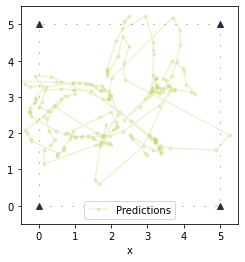

In [20]:
pos_df_filtered = kalman_filter_df(pos_df)

plot_results_pos_overall(pos_df_filtered)

saving file data/lenz_rep/results/measurements.png


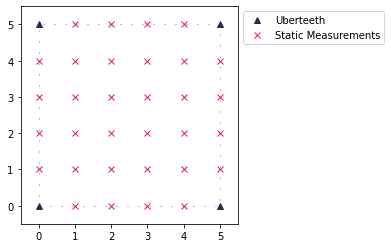

In [16]:
plot_padding = 0.5

ax = plt.subplot(xlim=plot_lim_x, ylim=plot_lim_y)

ax.set_aspect("equal")

rect1 = patches.Rectangle((room_lim_x[0], room_lim_y[0]), room_lim_x[1], room_lim_y[1], linewidth=1,
                              edgecolor='gray', facecolor='none', linestyle=(0, (1, 10)))
ax.add_patch(rect1)

device_coords = np.transpose([d1_coord, d2_coord, d3_coord, d4_coord])
ax.plot(*device_coords, marker="^", color="#2E294E", linestyle='None', label="Uberteeth")

measurement_points = np.transpose(list(map(lambda x: x[1], experiments)))

ax.plot(*measurement_points, marker="x", color="#D7263D", label="Static Measurements", linestyle='None')
lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
file = f"data/lenz_rep/results/measurements_static.png"
print(f'saving file {file}')
plt.savefig(file, bbox_inches='tight', dpi=300)
plt.show()


saving file data/lenz_rep/results/measurements_dynamic.png


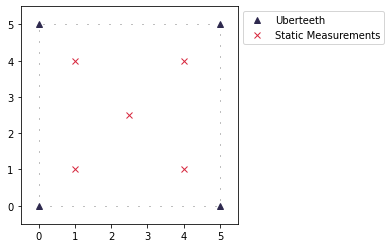

In [5]:
plot_padding = 0.5

ax = plt.subplot(xlim=plot_lim_x, ylim=plot_lim_y)

ax.set_aspect("equal")

rect1 = patches.Rectangle((room_lim_x[0], room_lim_y[0]), room_lim_x[1], room_lim_y[1], linewidth=1,
                              edgecolor='gray', facecolor='none', linestyle=(0, (1, 10)))
ax.add_patch(rect1)

device_coords = np.transpose([d1_coord, d2_coord, d3_coord, d4_coord])
ax.plot(*device_coords, marker="^", color="#2E294E", linestyle='None', label="Uberteeth")

measurement_points = np.transpose([pos1, pos2, pos3, pos4, pos5])

ax.plot(*measurement_points, marker="x", color="#D7263D", label="Dynamic Measurements", linestyle='None')
lgd = plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
file = f"data/lenz_rep/results/measurements_dynamic.png"
print(f'saving file {file}')
plt.savefig(file, bbox_inches='tight', dpi=300)
plt.show()


In [25]:
df1_2 = filter_df_w_interval(pos_df_filtered, (i1[1], i2[0]))
df2_3 = filter_df_w_interval(pos_df_filtered, (i2[1], i3[0]))
df3_4 = filter_df_w_interval(pos_df_filtered, (i3[1], i4[0]))
df4_5 = filter_df_w_interval(pos_df_filtered, (i4[1], i5[0]))



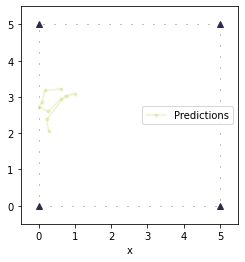

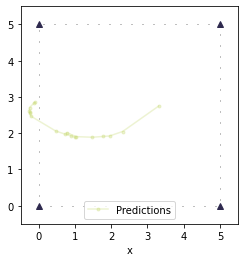

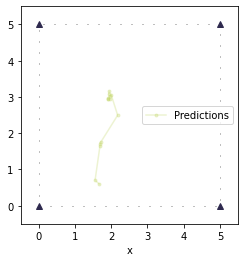

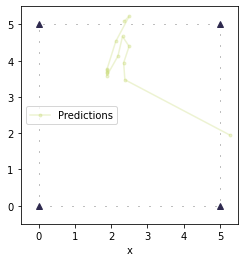

In [26]:
plot_results_pos_overall(df1_2)
plot_results_pos_overall(df2_3)
plot_results_pos_overall(df3_4)
plot_results_pos_overall(df4_5)


In [10]:
df1.shape


(36, 6)

In [11]:
df2.shape

(33, 6)

In [12]:
df3.shape

(26, 6)

In [13]:
df4.shape

(26, 6)

In [1]:
import numpy as np
np.mean([22.25, 20.25, 22.25, 28.0, 35.0, 40.25, 36.0, 27.0, 18.5, 20.75, 15.75, 16.5, 16.25, 25.5, 30.0, 24.0, 13.0, 17.25, 20.0, 18.5, 20.0, 14.0, 11.25, 22.0, 19.25, 21.5, 26.75, 23.0, 26.5, 34.75, 24.25, 25.0])



22.9765625

In [6]:
np.mean([20.25, 35.0, 36.0, 30.0, 17.25, 22.0, 19.25, 21.5, 26.75, 25.0])



25.3

In [7]:
np.mean([2.244, 1.737, 0.729, 1.379, 1.905, 1.326, 0.816, 0.385, 1.590, 2.967])

1.5078

In [15]:
np.mean([1.263, 1.255, 2.320, 1.065, 1.129])



1.4063999999999997

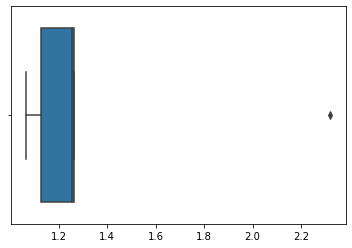

In [2]:
import seaborn as sb
sbplt = sb.boxplot([1.263, 1.255, 2.320, 1.065, 1.129]).get_figure()
sbplt.savefig("error_dist_exp2_p2")


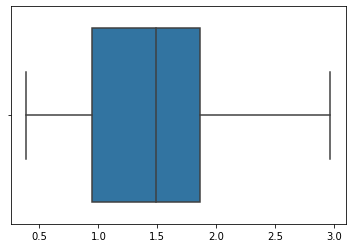

In [3]:
sbplt = sb.boxplot([2.244, 1.737, 0.729, 1.379, 1.905, 1.326, 0.816, 0.385, 1.590, 2.967]).get_figure()
sbplt.savefig("error_dist_exp2_p1")
